In [ ]:
#Let's make sure to know which labels go with which distance features...

In [132]:
from collections import defaultdict
import csv
from itertools import islice
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm_notebook
import torch
from torchvision import models, transforms, datasets

In [2]:
gpu_device = torch.device(3)
print(gpu_device.type)
print(torch.cuda.get_device_properties(gpu_device)) #/ 1024 / 1024 /1024
cpu_device = torch.device('cpu')
print(cpu_device.type)

cuda
_CudaDeviceProperties(name='GeForce GTX 1080', major=6, minor=1, total_memory=8119MB, multi_processor_count=20)
cpu


In [3]:
inception_transforms = transforms.Compose([
            transforms.Resize(299),
            #transforms.CenterCrop(constants.INPUT_SIZE),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

In [4]:
labeled_progan = datasets.ImageFolder('imgs_by_label/progan_labeled/', inception_transforms)
print(labeled_progan)
labeled_progan_loader = torch.utils.data.DataLoader(
        labeled_progan, batch_size=1, shuffle=False, num_workers=1)

Dataset ImageFolder
    Number of datapoints: 2233
    Root Location: imgs_by_label/progan_labeled/
    Transforms (if any): Compose(
                             Resize(size=299, interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                         )
    Target Transforms (if any): None


In [5]:
def get_inception_features(img, device=None):
    inception_net = models.inception_v3(pretrained=True, transform_input=True).to(device)
    
    layers_to_grab = [inception_net.Conv2d_1a_3x3, inception_net.Conv2d_2b_3x3,
                 inception_net.Conv2d_3b_1x1, inception_net.Mixed_5d, inception_net.Mixed_6e,
                 inception_net.Mixed_7c, inception_net.fc]
    
    layer_features = [None for i in range(len(layers_to_grab))]
    
    
    def hook_fn(self, inp, out, container, layer_index):
        #print(layer_index, inp[0].shape, out.shape)

        num_channels = out.shape[1]
        if len(out.shape) > 2:
            #Warning: this will break for batch sizes > 1
            cur_features = out.squeeze().permute(1,2,0).reshape(-1, num_channels)
        else:
            cur_features = out

        if container[layer_index] is None:
            container[layer_index] = [cur_features]
        else:
            #container[layer_index] = torch.cat((container[layer_index], cur_features))
            container[layer_index].append(cur_features)

    def hook_fn_i(container, i):
        return lambda self, inp, out: hook_fn(self, inp, out, container, i)

    for i, layer in enumerate(layers_to_grab):
        layer.register_forward_hook(hook_fn_i(layer_features, i))
        
    inception_net.eval()

    out = inception_net(x.to(device))
    del(out)
        
    #for x in img_iter:
        #print(x.shape, y)
        #plt.imshow((x).squeeze().permute(1, 2, 0))
        #plt.show()
        #out = inception_net(x.to(device))
        #del(out)
        #print(out.sum())
        
    return layer_features

In [6]:
#TODO: Parallelize as much as possible within memory
#TODO: Run on GPU, see if it's faster

# Features (for single image): #layers x (H*W for that layer) x (C for that layer)
# Reference set (for N comparison images): # layers x (N*H*W for that layer) x (C for that layer)
def layerwise_nn_features(features, reference_set, device, batch_size=1):
    
    assert(len(features) == len(reference_set))
    L = len(features)
    #print(L)
    mean_layer_closest_dists = torch.zeros(L).to(device)
    
    for l in range(L):
        #print(l)
        lf = features[l].detach().to(device) #layer features
        rlf = reference_set[l].detach().to(device) #reference layer features

        #layer is HxWxC
        #rlf[i] is NxC
        HtimesW,C = lf.shape
        N,C2 = rlf.shape
        assert(C == C2)
        
        rlf = rlf.reshape(1, N, C).detach()
        
        
        num_batches = HtimesW // batch_size
        if HtimesW % batch_size != 0: num_batches += 1 # for the fractional batch
            
        #Loop through each feature vector, we can parallelize later...
        #Note: if batch size does not divide HtimesW, this will miss the last HtimesW%batch_size vectors
        for b in range(num_batches):
            x = lf[b*batch_size : (b+1) * batch_size].reshape(-1, 1, C)
            cur_batch_size = x.shape[0]
            
            #Differences from vector to all reference vectors in that layer
            diffs = (x - rlf).detach()
            assert(diffs.shape == (cur_batch_size, N, C))
            
            sqr_dists = torch.sum(diffs**2, dim=2).detach()
            assert(sqr_dists.shape == (cur_batch_size, N))
            
            min_sqr_dists = torch.min(sqr_dists, dim=1)[0].detach()
            assert(min_sqr_dists.shape == (cur_batch_size,))
            
            min_dists = torch.sqrt(min_sqr_dists).detach()
            assert(min_dists.shape == (cur_batch_size,))
            
            mean_layer_closest_dists[l] += torch.sum(min_dists).detach()
            
            del x
            del diffs
            del sqr_dists
            del min_sqr_dists
            del min_dists
            
        mean_layer_closest_dists[l] /= (HtimesW)
        
        del lf
        del rlf
   
    return mean_layer_closest_dists

In [9]:
small_celeba_features = torch.load('small_celeba_features.pt', map_location=torch.device('cpu'))

[layer_feats.shape for layer_feats in small_celeba_features]

[torch.Size([10000, 32]),
 torch.Size([10000, 64]),
 torch.Size([10000, 80]),
 torch.Size([10000, 288]),
 torch.Size([10000, 768]),
 torch.Size([10000, 2048]),
 torch.Size([734, 1000])]

In [35]:
progan_filenames = []
progan_distance_features = []

with torch.no_grad():
    for i, (x,y) in enumerate(tqdm_notebook(labeled_progan_loader)):
        filename, _ = labeled_progan_loader.dataset.samples[i]
        progan_filenames.append(filename)
        #print(filename)
        #display(Image(filename=filename))

        #plt.imshow((x).squeeze().permute(1, 2, 0))
        #plt.show()

        inception_features = get_inception_features(x, gpu_device)
        flat_inception_features = [tmp[0] for tmp in inception_features]
        
        # For the first two layers (the largest), only take every other feature vector to save on compute
        for dim in [0,1]:
            L = len(flat_inception_features[dim])
            flat_inception_features[dim] = flat_inception_features[dim][range(0,L,2)]
        #print([tmp.shape for tmp in flat_inception_features])
        
        distance_features = layerwise_nn_features(flat_inception_features, small_celeba_features, gpu_device, 32)
        #print(distance_features)
        progan_distance_features.append(distance_features.cpu().detach().numpy())
        
        del inception_features
        del flat_inception_features
        del distance_features
        
        

        

In [36]:
torch.save(progan_filenames, 'progan_filenames.pt')
torch.save(progan_distance_features, 'progan_distance_features.pt')

In [ ]:
progan_filenames

In [ ]:
[torch.Tensor(x) for x in progan_distance_features]

In [37]:
len(progan_filenames), len(progan_distance_features)

(2233, 2233)

In [ ]:
progan_distance_features

In [ ]:
progan_filenames

In [45]:
dataset_counts = defaultdict(int)
img_counts = defaultdict(lambda : defaultdict(int))
unique_imgs = defaultdict(set)
img_votes = defaultdict(lambda: defaultdict(lambda: [0,0])) #no,yes tuples by dataset and image

with open('../all_gans_inf.csv') as f:
    reader = csv.DictReader(f)
    for row in islice(reader, None):
        img = row['img']        
#         dataset_name = img[:img.index('/')]
        split_name = img.split('/')
        assert(len(split_name) == 2)
        dataset_name, img_name = split_name
        
        vote_index = 1 if row['correctness'] == row['realness'] else 0
        img_votes[dataset_name][img_name][vote_index] += 1
        
        dataset_counts[dataset_name] += 1
        img_counts[dataset_name][img_name] += 1
unique_imgs = {dataset: len(img_counts[dataset]) for dataset in img_counts}

In [50]:
progan_labeled_set = set(img_votes['progan5000'].keys())

In [63]:
progan_processed_set = set([os.path.split(x)[-1] for x in progan_filenames])

In [68]:
#Confirming we have features for the same images we have human labels for!
progan_labeled_set == progan_processed_set 


#len(progan_labeled_set), len(progan_processed_set)
#progan_labeled_set.difference(progan_processed_set)
#progan_processed_set.difference(progan_labeled_set)
#os.path.split(progan_filenames[0])[-1]

True

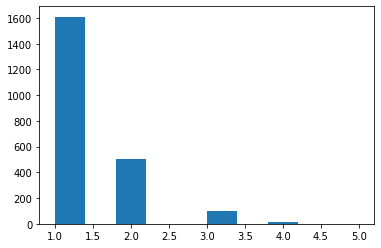

In [77]:
num_votes = [x+y for x,y in img_votes['progan5000'].values()]
plt.hist(num_votes)
plt.show()
#Most images have 1 label, most others have 2, a few with 3 or 4
#So logistic regression is a good model

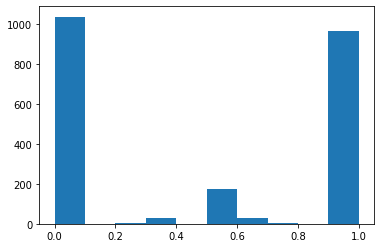

In [79]:
vote_pct_correct = [y/(x+y) for x,y in img_votes['progan5000'].values()]
plt.hist(vote_pct_correct)
plt.show()

0
1


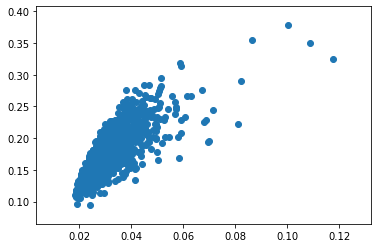

2


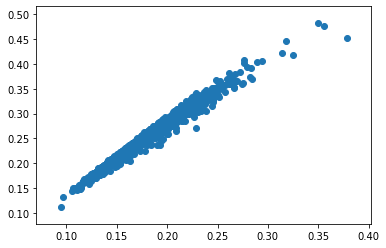

3


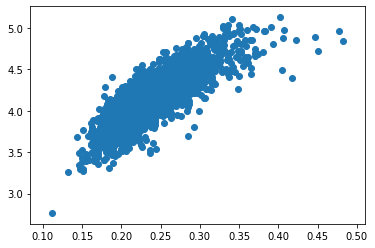

4


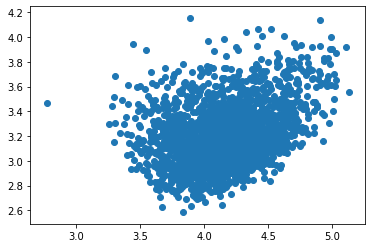

5


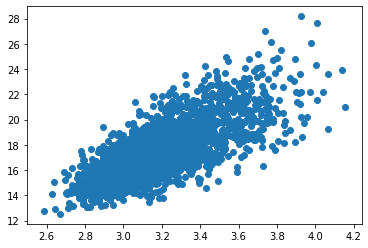

6


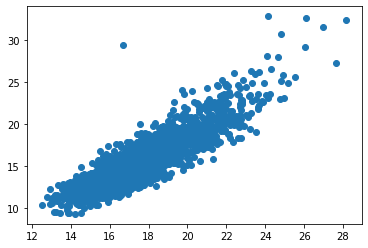

In [96]:
L = len(progan_distance_features[0])
feats_by_layer = [[],[],[],[],[],[],[]]
for l in range(L):
    print(l)
    cur_feats = [x[l] for x in progan_distance_features]
    feats_by_layer[l] = cur_feats
    #plt.hist(cur_feats)
    #plt.show()
    if l > 0:
        plt.scatter(feats_by_layer[l-1], feats_by_layer[l])
        plt.show()

plt.show()
# Adjacent layers are highly correlated to each other -
# so we could probably get a similar amount of signal by using fewer layers
# (only need to look at adjacent ones because activations for layer i+1 are independent of
# layer i-1 activations when conditioned on layer i - analogous to Markov property)

In [105]:
x = os.path.split(progan_filenames[0])[-1]
y = progan_distance_features[0]
 = img_votes['progan5000'][x]
x, y, l

('celeba_proGAN_1.png',
 array([ 0.03199681,  0.22382165,  0.32892337,  4.854051  ,  3.6655123 ,
        20.600561  , 18.892668  ], dtype=float32),
 [0, 3])

In [125]:
#split into train, val, test
#then do logistic regression on train, check on val!

#Let's split such that train set is 0 through 7 mod 10, val is 8 mod 10, test is 9 mod 10
N = len(progan_filenames)
train_indices = [i for i in range(N) if i % 10 in range(8)]
val_indices =   [i for i in range(N) if i % 10 == 8]
test_indices =  [i for i in range(N) if i % 10 == 9]

ltrain = len(train_indices)
lval = len(val_indices)
ltest = len(test_indices)
print(ltrain, lval, ltest, ltrain+lval+ltest, N)

train_files = [progan_filenames[i] for i in train_indices]
val_files = [progan_filenames[i] for i in val_indices]
test_files = [progan_filenames[i] for i in test_indices]


1787 223 223 2233 2233


In [130]:
with open('train_set.txt', 'w') as f:
    for x in train_files:
        f.write(x + '\n')
        
with open('val_set.txt', 'w') as f:
    for x in val_files:
        f.write(x + '\n')
        
with open('test_set.txt', 'w') as f:
    for x in test_files:
        f.write(x + '\n')

In [136]:
features_by_file = {progan_filenames[i] : progan_distance_features[i] for i in range(len(progan_filenames))}
len(features_by_file)

2233

In [151]:
votes_by_file = {'imgs_by_label/progan_labeled/progan_labeled_imgs/' + k : v for k,v in img_votes['progan5000'].items()}
len(votes_by_file)

2234

In [164]:
#vote of 1 is correctly spotting the fakeness, vote of 0 is being fooled
X = []
Y = []
for f in tqdm_notebook(train_files):
    cur_feats = features_by_file[f]
    cur_votes = votes_by_file[f]
    false_votes, true_votes = cur_votes
    #print(false_votes + true_votes)
    #print(f, cur_feats, cur_votes, '\n')
    
    for i in range(false_votes):
        X.append(cur_feats)
        Y.append(0)
        
    for i in range(true_votes):
        X.append(cur_feats)
        Y.append(1)
#print(X)
#print(Y)

len(X), len(Y)

(2369, 2369)

In [167]:
lr = LogisticRegression().fit(X, Y)

/home/alex/anaconda3/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [168]:
lr.score(X, Y)

0.6373997467285775

In [169]:
#vote of 1 is correctly spotting the fakeness, vote of 0 is being fooled
X_val = []
Y_val = []
for f in tqdm_notebook(val_files):
    cur_feats = features_by_file[f]
    cur_votes = votes_by_file[f]
    false_votes, true_votes = cur_votes
    
    for i in range(false_votes):
        X_val.append(cur_feats)
        Y_val.append(0)
        
    for i in range(true_votes):
        X_val.append(cur_feats)
        Y_val.append(1)
#print(X)
#print(Y)

In [171]:
lr.score(X_val, Y_val)

0.6503267973856209

0.5511172516111708 0.14103717787422126


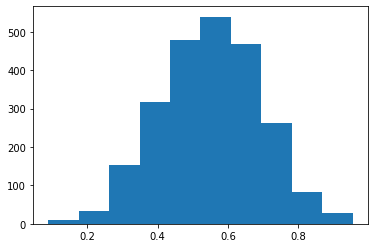

In [185]:
probs = lr.predict_proba(X)
true_probs = np.array([probs[i][Y[i]] for i in range(len(probs))])

plt.hist(true_probs)
print(np.mean(true_probs), np.std(true_probs))

0.5504042580275317 0.13469727561829564


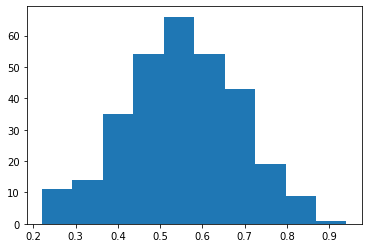

In [187]:
val_probs = lr.predict_proba(X_val)
true_val_probs = np.array([val_probs[i][Y_val[i]] for i in range(len(val_probs))])

plt.hist(true_val_probs)
print(np.mean(true_val_probs), np.std(true_val_probs))